# Brain-Tumor-Classification with Transfer Learning

In [1]:
## Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Import required libraries

In [2]:
# General Imports
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd 
import tensorflow as tf

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Building Model
from keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Training Model callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

In [3]:
# Global variables
SAVE = False
SEED = 111


# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Check Device 

In [4]:
# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.10.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load Datasets

In [5]:
# Directories for training and testing data
USER_PATH = os.path.join(r"C:\Users\USER\DataScience\DeepLearning\Brain_Tumor\brain-tumor-mri-dataset_n")
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'


# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


In [6]:
# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


## Data Visualization

In [7]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)


In [8]:
print(train_counts)
print(test_counts)

[1321 1339 1595 1457]
[300 306 405 300]


In [9]:
# Number of classes
len(os.listdir(train_dir))

4

In [10]:
# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

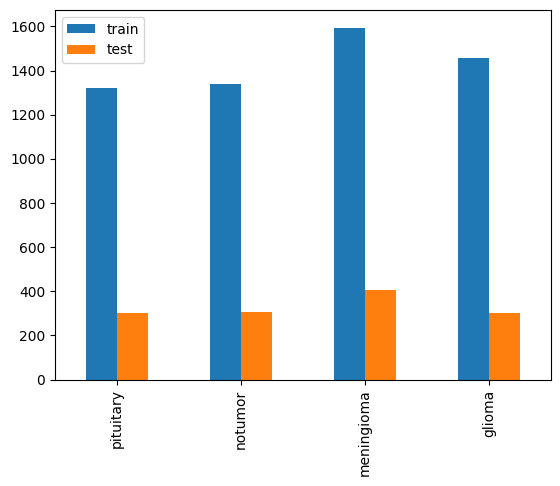

In [11]:
pd.DataFrame({'train': train_counts, "test": test_counts}, index = CLASS_TYPES).plot.bar()

plt.show()

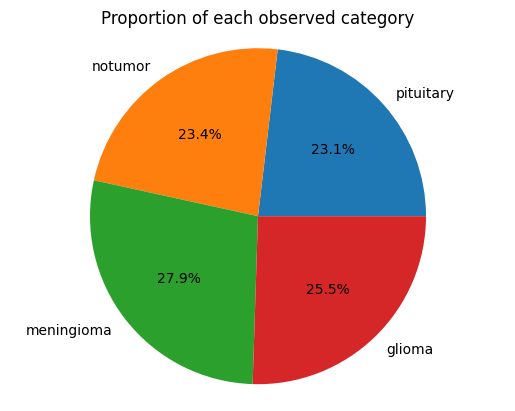

In [12]:
# For train category

plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=CLASS_TYPES,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

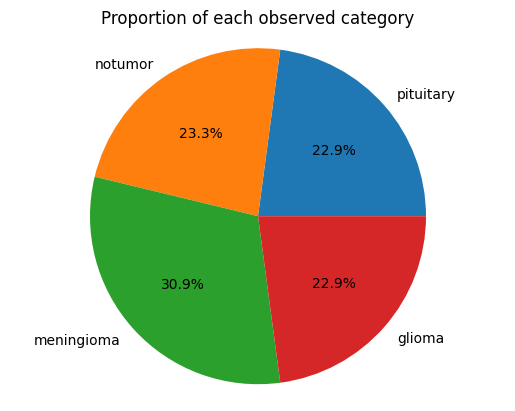

In [13]:
# For test category
plt.pie(test_counts,
        explode=(0, 0, 0, 0) , 
        labels=CLASS_TYPES,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Display input images for sanity check


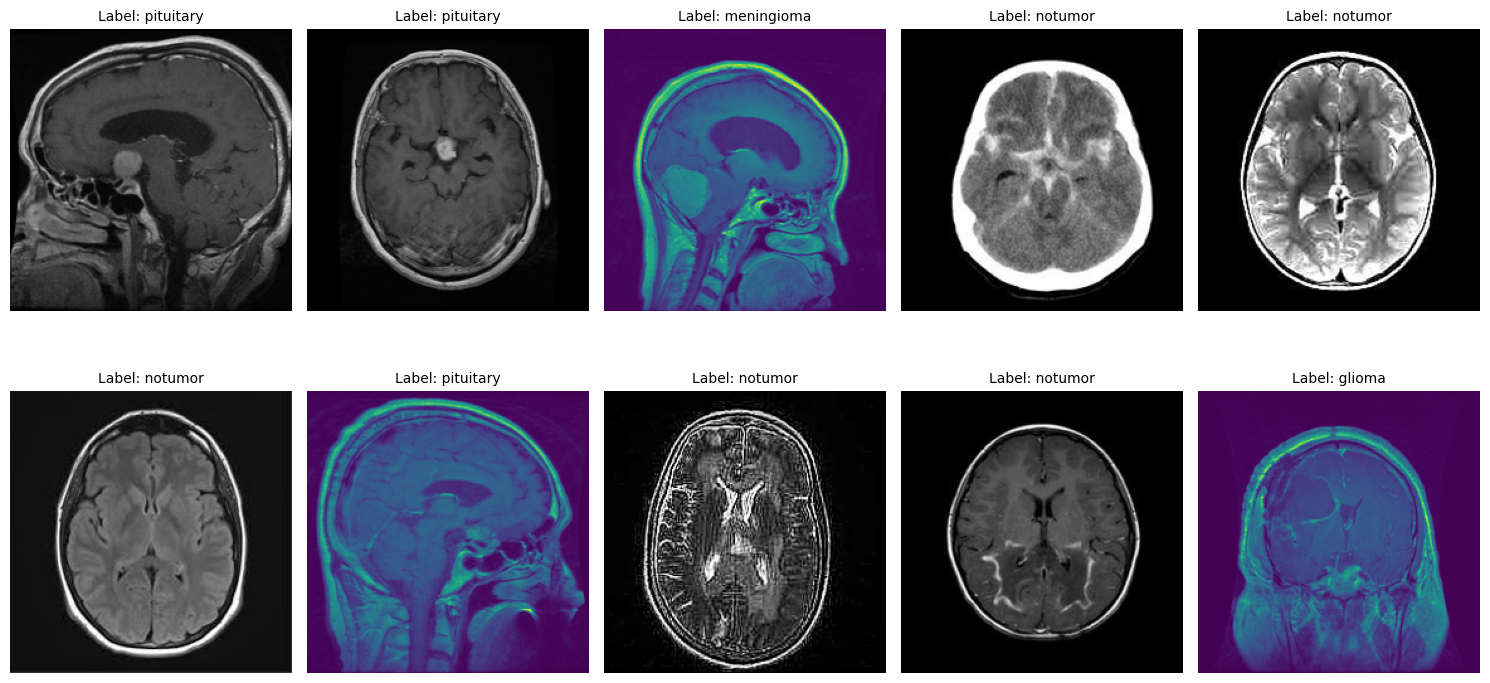

In [14]:
from PIL import Image

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224)) # Resize to consistent size
    
    # Display Images
    axes[i].imshow(img)
    axes[i].axis('off') # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)
    
plt.tight_layout()
plt.show;

## Image DataGenerator

In [15]:
# Image size
IMAGE_SIZE = (128, 128)

# Training batch size
batch_size = 32

In [16]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)



# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)


# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Check image classes

In [17]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)
# print(class_indices_train_list)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [18]:
# Image shape: height, width, RBG
image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Training epochs
epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (128, 128, 3)
Epochs: 50
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


## Custom Model Building

In [19]:
# Define the model architecture
model = Sequential()
    
# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (4, 4), activation="relu", strides=1, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (4, 4), activation="relu", strides=1, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 3)))      

# Convolutional layer 4
model.add(Conv2D(128, (4, 4), activation="relu", strides=1, padding="same"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2, seed=SEED))
model.add(Dense(N_TYPES, activation="softmax"))



In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [21]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])


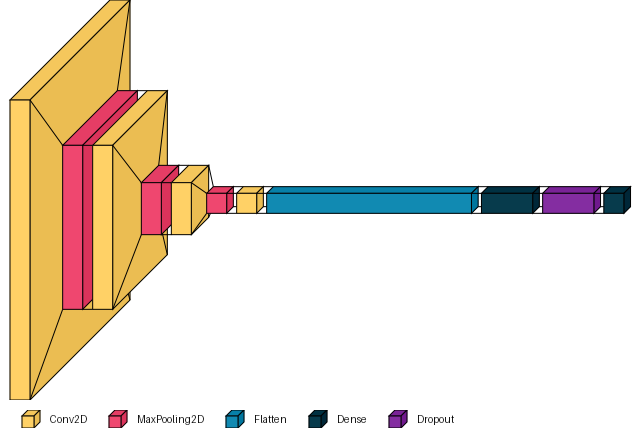

In [22]:
# pip install Pillow==9.5.0

import visualkeras

visualkeras.layered_view(model, legend=True, draw_volume=True, max_xy=300)


## Call backs

In [23]:
# Implement callbacks 
checkpoint = ModelCheckpoint('MODELS/Custom_model.keras', 
                             save_best_only=True, 
                             save_weights_only=False)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.1, 
    patience=10, 
    verbose = 1, 
    mode='min', 
    restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 10, 
    verbose = 1, 
    factor = 0.1, 
    min_delta=0.0001,
    min_lr = 0.1)


# putting the call backs into a callback list
callbacks = [early_stop, checkpoint, learning_rate_reduction]


In [24]:
# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

Epoch 1/50
178/178 [==============================] - 53s 250ms/step - loss: 0.9726 - accuracy: 0.5697 - val_loss: 0.9627 - val_accuracy: 0.6109 - lr: 1.0000e-04
Epoch 2/50
178/178 [==============================] - 41s 231ms/step - loss: 0.6623 - accuracy: 0.7458 - val_loss: 0.8074 - val_accuracy: 0.7133 - lr: 1.0000e-04
Epoch 3/50
178/178 [==============================] - 40s 226ms/step - loss: 0.5508 - accuracy: 0.7837 - val_loss: 0.6403 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 4/50
178/178 [==============================] - 55s 311ms/step - loss: 0.4793 - accuracy: 0.8134 - val_loss: 0.5776 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 5/50
178/178 [==============================] - 43s 242ms/step - loss: 0.4337 - accuracy: 0.8329 - val_loss: 0.6510 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 6/50
178/178 [==============================] - 46s 260ms/step - loss: 0.3767 - accuracy: 0.8593 - val_loss: 0.5023 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 7/50
178/178 [========

In [25]:
history.history

{'loss': [0.9725650548934937,
  0.662266731262207,
  0.5507547855377197,
  0.47934749722480774,
  0.43372076749801636,
  0.3767356872558594,
  0.3630923926830292,
  0.3095771372318268,
  0.2947424650192261,
  0.26709580421447754,
  0.2429480105638504,
  0.2252938449382782,
  0.2207147777080536,
  0.18846353888511658,
  0.19741040468215942,
  0.17197762429714203,
  0.149060919880867,
  0.14400672912597656,
  0.13516943156719208,
  0.13609936833381653,
  0.12296973168849945,
  0.1184128001332283,
  0.1163320392370224,
  0.10217642784118652],
 'accuracy': [0.5696980357170105,
  0.7457746267318726,
  0.783707857131958,
  0.8133803009986877,
  0.8329225182533264,
  0.8593310117721558,
  0.8565140962600708,
  0.8808098435401917,
  0.8876760601997375,
  0.8980633616447449,
  0.9116197228431702,
  0.9130281805992126,
  0.922183096408844,
  0.9302816987037659,
  0.9295774698257446,
  0.9397887587547302,
  0.9466549158096313,
  0.9491197466850281,
  0.9529929757118225,
  0.9498239159584045,
  0.

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [27]:
df_history = pd.DataFrame(history.history)
df_history.head()


,loss,accuracy,val_loss,val_accuracy,lr
0,0.972565,0.569698,0.962694,0.610937,0.0001
1,0.662267,0.745775,0.807400,0.713281,0.0001
2,0.550755,0.783708,0.640267,0.737500,0.0001
3,0.479347,0.813380,0.577597,0.778125,0.0001
4,0.433721,0.832923,0.650976,0.762500,0.0001


## Model Evaluation

In [28]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")


40/40 [==============================] - 3s 68ms/step - loss: 0.2052 - accuracy: 0.9289
Test Loss: 0.20518
Test Accuracy: 0.92891


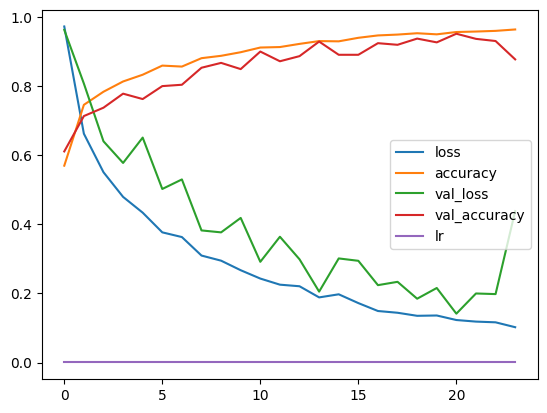

In [29]:
df_history.plot();

## Accuracy and Loss plot 

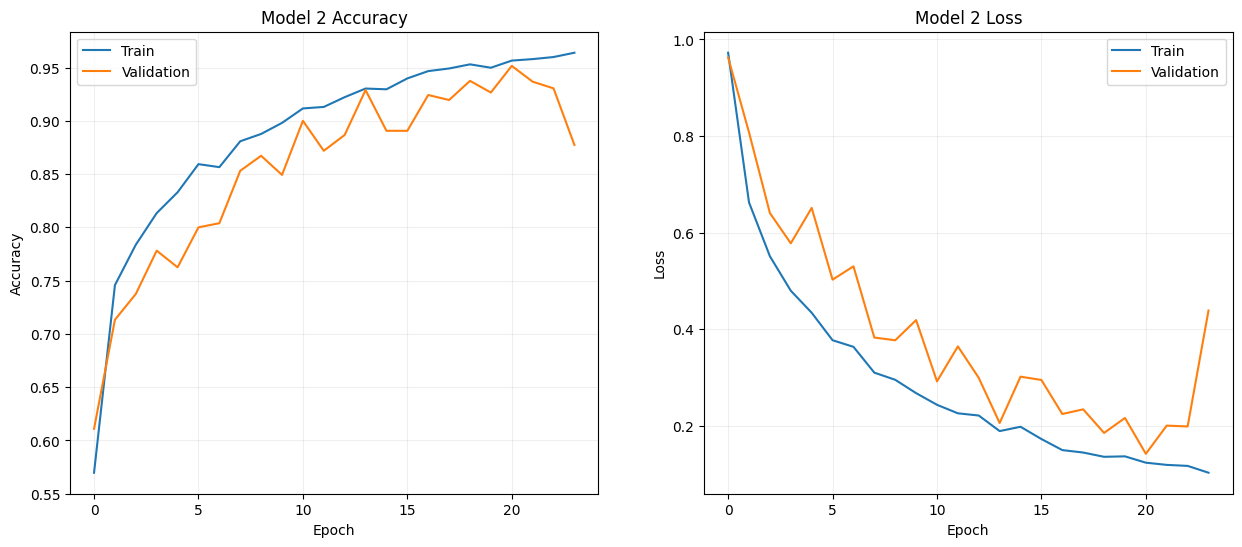

In [30]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

## Save the model

In [31]:
model.save('MODELS/Brain_tumor_custom_model.keras')

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(test_generator)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

41/41 [==============================] - 3s 71ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [33]:
# train and validation samples

nb_train_samples = 5712   
nb_validation_samples = 1311   

In [35]:
# Displaying the Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

class_labels = {0:'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary' }

Y_pred = model.predict_generator(test_generator, nb_validation_samples // batch_size+1) # put classifier not model
y_pred = np.argmax(Y_pred, axis=1)

#Classification Report
print('\n Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

#Confution Matrix
print('\n Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))



 Classification Report
              precision    recall  f1-score   support

      glioma       0.96      0.84      0.89       300
  meningioma       0.85      0.89      0.87       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311


 Confusion Matrix
[[251  42   2   5]
 [  7 273  19   7]
 [  1   4 400   0]
 [  2   2   0 296]]


## Confusion Matrix

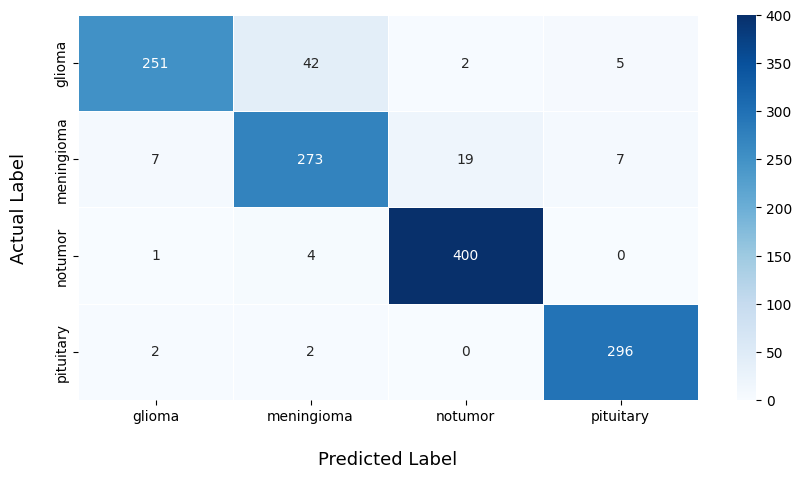

In [36]:
plt.figure(figsize=(10,5))

plt.style.use('default')

cm=confusion_matrix(test_generator.classes, y_pred)
labels = list(test_generator.class_indices.keys())

sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels, yticklabels=labels, cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [37]:
#load weights
model.load_weights('MODELS/Brain_tumor_custom_model.keras')
model.evaluate(test_generator)

41/41 [==============================] - 3s 65ms/step - loss: 0.2014 - accuracy: 0.9306


[0.20135633647441864, 0.9305873513221741]

# Transfer Learning Model

## VGG16 Model

In [21]:
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.layers import Input

In [22]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model_vgg = Sequential()
model_vgg.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model_vgg.add(base_model)  # Add VGG16 base model
model_vgg.add(Flatten())  # Flatten the output of the base model
model_vgg.add(Dropout(0.3))  # Dropout layer for regularization
model_vgg.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model_vgg.add(Dropout(0.2))  # Dropout layer for regularization
model_vgg.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation


In [23]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [24]:
# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.869, beta_2=0.995),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Call backs

In [25]:
# Implement callbacks 
checkpoint = ModelCheckpoint('MODELS/BT_CL_VGG16_model.keras', 
                             save_best_only=True, 
                             save_weights_only=False)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.1, 
    patience=10, 
    verbose = 1, 
    mode='min', 
    restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 10, 
    verbose = 1, 
    factor = 0.1, 
    min_delta=0.0001,
    min_lr = 0.1)


# putting the call backs into a callback list
callbacks = [early_stop, checkpoint, learning_rate_reduction]


In [26]:
# Training the model
history = model_vgg.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

Epoch 1/50
178/178 [==============================] - 55s 251ms/step - loss: 0.4783 - accuracy: 0.8172 - val_loss: 0.3889 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 2/50
178/178 [==============================] - 39s 218ms/step - loss: 0.2675 - accuracy: 0.9035 - val_loss: 0.3510 - val_accuracy: 0.8641 - lr: 1.0000e-04
Epoch 3/50
178/178 [==============================] - 37s 210ms/step - loss: 0.1929 - accuracy: 0.9301 - val_loss: 0.2023 - val_accuracy: 0.9187 - lr: 1.0000e-04
Epoch 4/50
178/178 [==============================] - 37s 208ms/step - loss: 0.1510 - accuracy: 0.9456 - val_loss: 0.1260 - val_accuracy: 0.9625 - lr: 1.0000e-04
Epoch 5/50
178/178 [==============================] - 37s 205ms/step - loss: 0.1284 - accuracy: 0.9528 - val_loss: 0.2351 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 6/50
178/178 [==============================] - 37s 210ms/step - loss: 0.0977 - accuracy: 0.9634 - val_loss: 0.1775 - val_accuracy: 0.9422 - lr: 1.0000e-04
Epoch 7/50
178/178 [========

In [27]:
history.history


{'loss': [0.4783417284488678,
  0.26746666431427,
  0.19286547601222992,
  0.1509990245103836,
  0.12835048139095306,
  0.09769511967897415,
  0.09326045215129852,
  0.0817236453294754,
  0.06779147684574127,
  0.06085257604718208,
  0.04922019690275192,
  0.040729720145463943,
  0.05077191814780235,
  0.03318013250827789,
  0.04149426147341728,
  0.03950400650501251,
  0.026974882930517197,
  0.023812493309378624,
  0.03633998706936836],
 'accuracy': [0.8172401785850525,
  0.9035211205482483,
  0.930126428604126,
  0.9455986022949219,
  0.952816903591156,
  0.9633802771568298,
  0.9667253494262695,
  0.9713028073310852,
  0.9765844941139221,
  0.9792253375053406,
  0.983450710773468,
  0.98591548204422,
  0.9811619520187378,
  0.9892605543136597,
  0.9864436388015747,
  0.9873239398002625,
  0.9919013977050781,
  0.9919013977050781,
  0.9880281686782837],
 'val_loss': [0.38892650604248047,
  0.35099363327026367,
  0.2023307830095291,
  0.12595435976982117,
  0.23513472080230713,
  0.1

In [28]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [29]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.478342,0.817240,0.388927,0.859375,0.0001
1,0.267467,0.903521,0.350994,0.864062,0.0001
2,0.192865,0.930126,0.202331,0.918750,0.0001
3,0.150999,0.945599,0.125954,0.962500,0.0001
4,0.128350,0.952817,0.235135,0.923437,0.0001


## Model Evaluation

In [30]:
# Evaluating the model
loss, accuracy = model_vgg.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")


40/40 [==============================] - 3s 60ms/step - loss: 0.0858 - accuracy: 0.9742
Test Loss: 0.08582
Test Accuracy: 0.97422


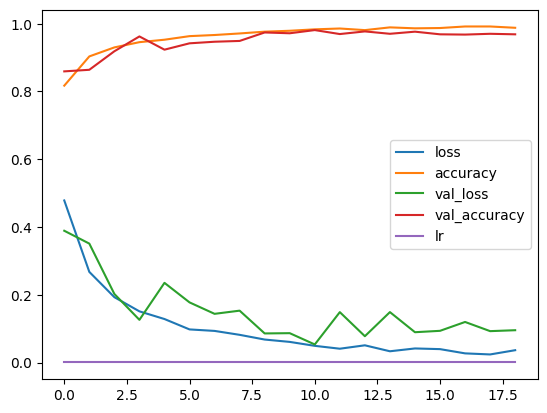

In [31]:
df_history.plot();

## Accuracy and Loss plot

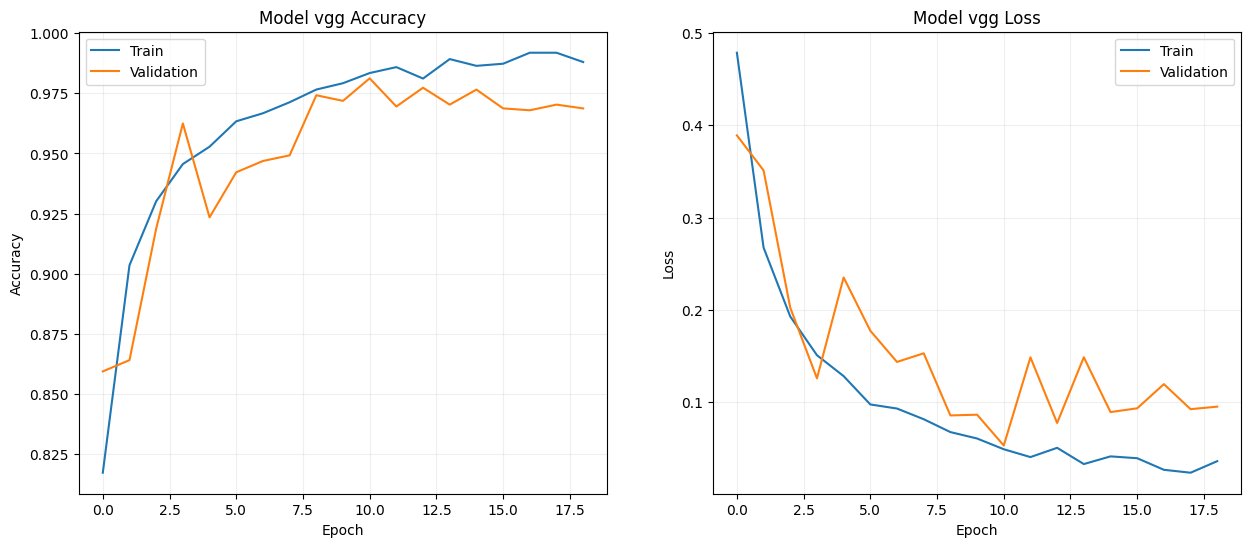

In [32]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model vgg Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model vgg Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

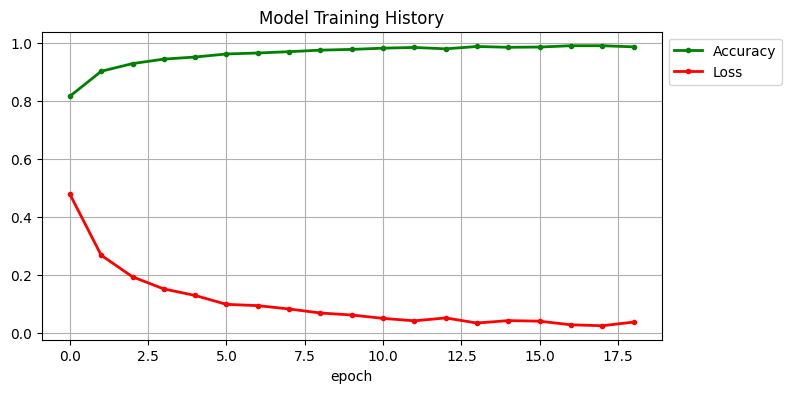

In [33]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
# plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



## Save the model

In [34]:
model_vgg.save('MODELS/BT_CL_VGG16_model.keras')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = model_vgg.predict(test_generator)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

12/41 [=======>......................] - ETA: 2s

In [ ]:
nb_train_samples = 5712   
nb_validation_samples = 1311   
epochs = 10

## Model Classification Report

In [55]:
from PIL import Image, ImageEnhance  # For image processing and enhancement

# Helper function
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

In [56]:
# Displaying the Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model_vgg.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 [==============================] - 3s 67ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       300
           1       0.86      0.96      0.91       306
           2       0.99      0.98      0.99       405
           3       0.97      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix:
[[262  37   0   1]
 [  2 294   2   8]
 [  3   7 395   0]
 [  1   4   0 295]]


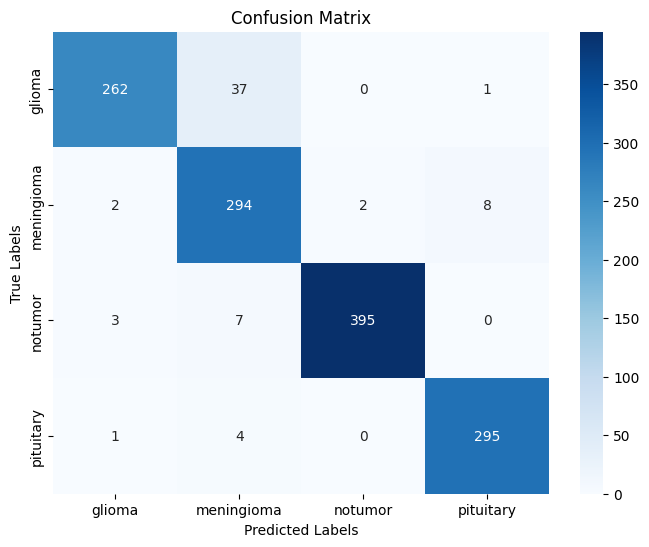

In [57]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Roc Curve Plot

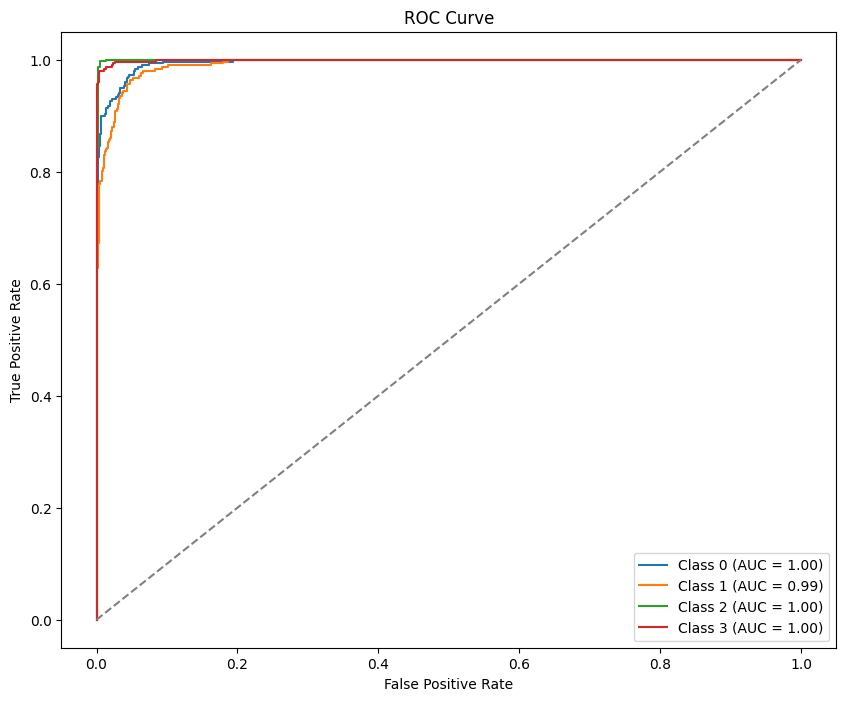

In [58]:
from sklearn.preprocessing import label_binarize

# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Load the model

In [1]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('MODELS/BT_CL_VGG16_model.keras')

## MRI Tumor Classificaiton System

In [2]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))
        
        

## Test Examples

1/1 [==============================] - 8s 8s/step


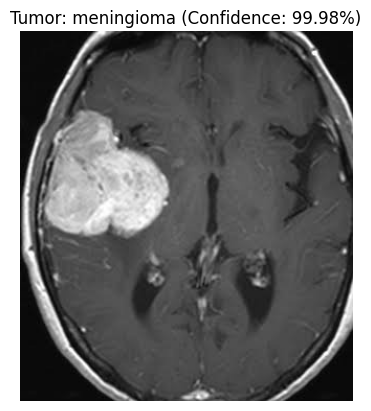

In [3]:
# Example usage
image_path = 'Test_images/Te-me_0025.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)


1/1 [==============================] - 0s 21ms/step


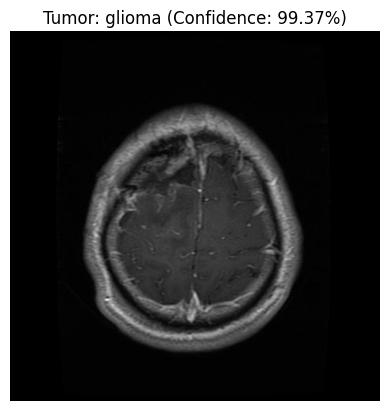

In [4]:
# Example usage
image_path = 'Test_images/Te-gl_0017.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 21ms/step


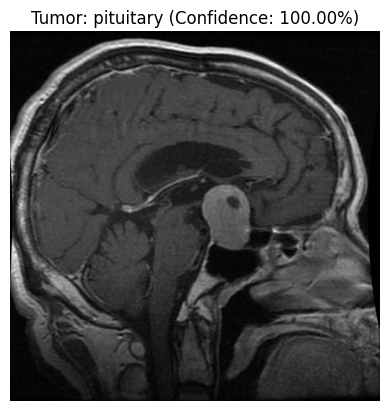

In [5]:
# Example usage
image_path = 'Test_images/Te-pi_0090.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 41ms/step


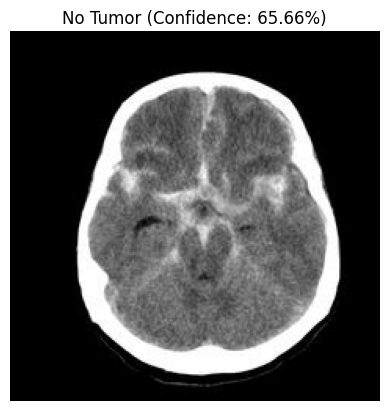

In [64]:
# Example usage
image_path = 'Test_images/Te-no_0011.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)